In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'2.2.0'

In [0]:
!pip install -q imageio       #to generate GIFs

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

4423680/4422102 [==============================] - 0s 0us/step


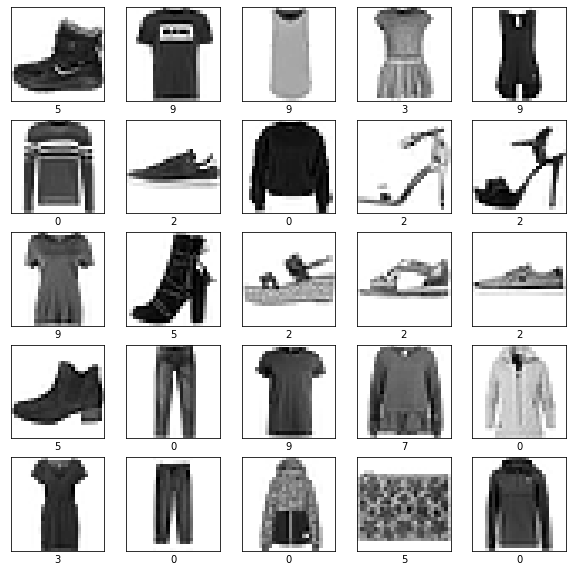

In [0]:
(train_images,train_labels),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[train_labels[i]])
plt.show()

In [0]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')                #reshape all images to [28,28,1]
train_images= (train_images-127.5) / 127.5                                      #noemalise images to [-1,1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
#Generator model
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))          #input is a vector of dimension [1,100]
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Reshape((7,7,256)))                                          #reshape to image of 7x7 and 256 channels
  assert model.output_shape == (None, 7 ,7 , 256)                               #None is the Batch_size 

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7,7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))       # stride=2 will double the image size
  assert model.output_shape == (None, 14,14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 28,28, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(1,(5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None,28,28,1)
  model.add(layers.Activation(tf.nn.tanh))
  model.summary()

  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
re_lu (ReLU)                 (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 7, 7, 128)         0

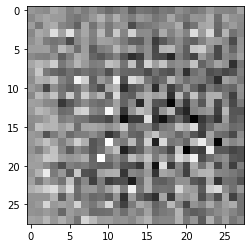

In [0]:
# try the generator model for a toy noise input
generator= make_generator_model()

noise = tf.random.normal([1,100])                                               #generate random noise 
generated_image = generator(noise,training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [0]:
#Build the discriminator model
# Discriminator is a simple CNN classifier
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(3,3),strides=(2,2),padding='same', input_shape=[28,28,1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128,(3,3),strides=(2,2),padding='same')) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    model.summary()
    return model


In [0]:
discriminator=make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [0]:
## Define LOSS functions for Generator and Discriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# Discriminator loss- The discriminator should output 1 if the input image is a real image and 0 if it is a fake image
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)             #true value=1, real_output from discriminator
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss+fake_loss
  return total_loss

#Generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)                  # want to make decision of fake output=1
  

In [0]:
generator_optimiser = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)
discriminator_optimiser = tf.keras.optimizers.Adam(learning_rate=2e-4,beta_1=0.5)

In [0]:
#saving checkpoints for saving and restoring models

checkpoint_dir= './training_checkpoints'
checkpoint_prefix= os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimiser=generator_optimiser,
                                 discriminator_optimiser=discriminator_optimiser,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
epochs= 500
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])                  #create a seed to be reused


In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output=fake_output)
    dis_loss = discriminator_loss(real_output=real_output, fake_output=fake_output)
    print(gen_loss, dis_loss)
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

  generator_optimiser.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimiser.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))



In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

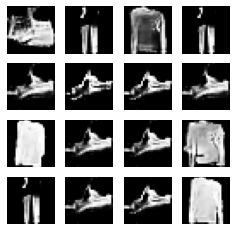

In [0]:
train(train_dataset, epochs)